In [9]:
%reload_ext autotime
import pandas as pd
import requests
import geopandas as gpd
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map
import time
import os
from glob import glob
from coastsat import SDS_transects
import json
import matplotlib.pyplot as plt

In [10]:
poly = gpd.read_file("polygons.geojson")
poly = poly[poly.id.str.startswith("nzd")]
poly.set_index("id", inplace=True)
poly

area id_sorted      northing  \
id                                              
nzd0001  3.069093e+06   nzd0001 -4.085604e+06   
nzd0002  1.507931e+06   nzd0002 -4.086100e+06   
nzd0003  2.484730e+06   nzd0003 -4.087232e+06   
nzd0006  9.619509e+05   nzd0004 -4.090732e+06   
nzd0007  3.109433e+06   nzd0005 -4.095516e+06   
...               ...       ...           ...   
nzd0317  9.986110e+05   nzd0556 -4.971830e+06   
nzd0316  4.300058e+06   nzd0557 -4.966165e+06   
nzd0313  2.291974e+07   nzd0558 -4.939929e+06   
nzd0314  3.124363e+07   nzd0559 -4.943102e+06   
nzd0561  8.710035e+05   nzd0560 -5.905869e+06   

                                                  geometry  
id                                                          
nzd0001  POLYGON ((172.96406 -34.43054, 172.99324 -34.4...  
nzd0002  POLYGON ((172.93456 -34.42857, 172.95856 -34.4...  
nzd0003  POLYGON ((173.0098 -34.42055, 173.00088 -34.44...  
nzd0006  POLYGON ((173.00532 -34.46694, 173.00612 -34.4...  
nzd0007  POLYGON ((172.99847 -34.48102, 173.00081 -34.5...  
...                                                    ...  
nzd0317  POLYGON ((172.32302 -40.7187, 172.3121 -40.728...  
nzd0316  POLYGON ((172.37076 -40.70229, 172.39571 -40.6...  
nzd0313  POLYGON ((172.89281 -40.50518, 172.73306 -40.5...  
nzd0314  POLYGON ((173.04122 -40.54521, 172.89309 -40.5...  
nzd0561  POLYGON ((168.53017 -46.77383, 168.52 -46.7786...  

[560 rows x 4 columns]

/tmp/ipykernel_3087672/1531560215.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  point = gpd.read_file("~/CoastSeg/bbox.geojson").geometry.centroid[0]


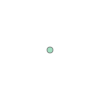

In [11]:
point = gpd.read_file("~/CoastSeg/bbox.geojson").geometry.centroid[0]
point

In [12]:
files = pd.DataFrame({"filename": sorted(glob("data/*/transect_time_series.csv"))})
files["sitename"] = files.filename.str.split("/").str[1]
files["have_tides"] = files.sitename.apply(lambda s: os.path.isfile(f"data/{s}/tides.csv"))
files

filename sitename  have_tides
0    data/nzd0001/transect_time_series.csv  nzd0001        True
1    data/nzd0002/transect_time_series.csv  nzd0002        True
2    data/nzd0003/transect_time_series.csv  nzd0003        True
3    data/nzd0004/transect_time_series.csv  nzd0004        True
4    data/nzd0005/transect_time_series.csv  nzd0005        True
..                                     ...      ...         ...
556  data/nzd0558/transect_time_series.csv  nzd0558        True
557  data/nzd0559/transect_time_series.csv  nzd0559        True
558  data/nzd0560/transect_time_series.csv  nzd0560        True
559  data/nzd0561/transect_time_series.csv  nzd0561        True
560  data/nzd0562/transect_time_series.csv  nzd0562        True

[561 rows x 3 columns]

In [13]:
def get_tide_for_dt(point, datetime):
    while True:
        try:
            r = requests.get("https://api.niwa.co.nz/tides/data", params={
                "lat": point.y,
                "long": point.x,
                "numberOfDays": 2,
                "startDate": str(datetime.date()),
                "datum": "MSL",
                "interval": 10, # 10 minute resolution
                "apikey": os.environ["NIWA_API_KEY"]
            }, timeout=(30,30))
        except Exception as e:
            print(e)
            time.sleep(5)
            continue
        if r.status_code == 200:
            df = pd.DataFrame(r.json()["values"])
            df.index = pd.to_datetime(df.time)
            return df.value[datetime]
        elif r.status_code == 429:
            sleep_seconds = 30
            # sleep for x seconds to refresh the count
            print(f'Num of API reqs exceeded, Sleeping for: {sleep_seconds} seconds...')
            time.sleep(sleep_seconds)

for sitename in tqdm(files[~files.have_tides].sitename):
    dates = pd.to_datetime(pd.read_csv(f"data/{sitename}/transect_time_series.csv").dates).dt.round("10min")
    #point = poly.geometry[sitename].centroid

    results = []
    for date in tqdm(dates):
        result = get_tide_for_dt(point, date)
        results.append({
            "dates": date,
            "tide": result
        })
    df = pd.DataFrame(results)
    df.set_index("dates", inplace=True)
    df.to_csv(f"data/{sitename}/tides.csv")

0it [00:00, ?it/s]

In [14]:
files["have_tides"] = files.sitename.apply(lambda s: os.path.isfile(f"data/{s}/tides.csv"))

In [15]:
# Transects, origin is landward. Has beach_slope
transects = gpd.read_file("transects_extended.geojson").to_crs(2193).drop_duplicates(subset="id")
transects.set_index("id", inplace=True)
transects

site_id  orientation  along_dist  along_dist_norm  beach_slope  \
id                                                                             
aus0001-0000  aus0001   104.347648    0.000000         0.000000        0.085   
aus0001-0001  aus0001    93.495734   98.408334         0.002935        0.050   
aus0001-0002  aus0001    82.069341  198.408334         0.005918        0.050   
aus0001-0003  aus0001    81.192757  298.402523         0.008900        0.055   
aus0001-0004  aus0001    81.065473  398.402523         0.011882        0.075   
...               ...          ...         ...              ...          ...   
nzd0562-0014  nzd0562          NaN         NaN              NaN        0.100   
nzd0562-0015  nzd0562          NaN         NaN              NaN        0.100   
nzd0562-0016  nzd0562          NaN         NaN              NaN        0.100   
nzd0562-0017  nzd0562          NaN         NaN              NaN        0.100   
nzd0562-0018  nzd0562          NaN         NaN              NaN        0.100   

                 cil     ciu     trend  n_points  n_points_nonan  r2_score  \
id                                                                           
aus0001-0000  0.0545  0.2000 -1.456305     654.0           342.0  0.131951   
aus0001-0001  0.0387  0.0640 -0.833581     654.0           473.0  0.052783   
aus0001-0002  0.0428  0.0647 -0.282209     654.0           491.0  0.008220   
aus0001-0003  0.0480  0.0659  0.089340     654.0           502.0  0.000987   
aus0001-0004  0.0614  0.0922  0.361437     654.0           508.0  0.017461   
...              ...     ...       ...       ...             ...       ...   
nzd0562-0014     NaN     NaN  0.273931     578.0           448.0  0.043350   
nzd0562-0015     NaN     NaN  0.146515     578.0           453.0  0.012178   
nzd0562-0016     NaN     NaN  0.134943     578.0           441.0  0.011499   
nzd0562-0017     NaN     NaN -0.024545     578.0           402.0  0.000288   
nzd0562-0018     NaN     NaN  0.227034     578.0           360.0  0.023506   

                    mae          mse       rmse   intercept  \
id                                                            
aus0001-0000  28.721214  1321.059410  36.346381  179.407277   
aus0001-0001  26.029482  1092.336862  33.050520  210.629160   
aus0001-0002  22.896464   838.997233  28.965449  200.166307   
aus0001-0003  20.770475   691.179232  26.290288  185.295473   
aus0001-0004  19.528839   637.676213  25.252252  169.027861   
...                 ...          ...        ...         ...   
nzd0562-0014   7.033638    88.106839   9.386524  193.225842   
nzd0562-0015   7.231123    90.897715   9.534029  195.599371   
nzd0562-0016   6.718444    81.706241   9.039150  204.695237   
nzd0562-0017   7.925532   112.159800  10.590552  209.429214   
nzd0562-0018   7.911070   115.739083  10.758210  209.376408   

                                                       geometry  
id                                                               
aus0001-0000  LINESTRING (-422245.836 7118667.88, -421827.54...  
aus0001-0001  LINESTRING (-422256.313 7118525.222, -421837.6...  
aus0001-0002  LINESTRING (-422219.773 7118383.012, -421816.8...  
aus0001-0003  LINESTRING (-422187.543 7118279.615, -421786.5...  
aus0001-0004  LINESTRING (-422155.665 7118178.983, -421754.9...  
...                                                         ...  
nzd0562-0014  LINESTRING (1770293.383 5917676.929, 1770648.7...  
nzd0562-0015  LINESTRING (1770254.942 5917751.29, 1770610.27...  
nzd0562-0016  LINESTRING (1770214.898 5917828.821, 1770573.4...  
nzd0562-0017  LINESTRING (1770180.582 5917901.338, 1770542.2...  
nzd0562-0018  LINESTRING (1770147.813 5917970.658, 1770509.4...  

[127404 rows x 16 columns]

In [17]:
def despike(chainage, threshold=10):
    chainage = chainage.dropna()
    chainage, dates = SDS_transects.identify_outliers(chainage.tolist(), chainage.index.tolist(), threshold)
    return pd.Series(chainage, index=dates)

def process_sitename(sitename):
    transects_at_site = transects[transects.site_id == sitename]
    assert len(transects_at_site)
    raw_intersects = pd.read_csv(f"data/{sitename}/transect_time_series.csv").drop(columns=["Unnamed: 0"])
    sat_times = pd.to_datetime(raw_intersects.dates).dt.round("10min")
    raw_intersects.set_index("dates", inplace=True)
    raw_intersects.index = pd.to_datetime(raw_intersects.index)
    tides = pd.read_csv(f"data/{sitename}/tides.csv")
    tides.set_index("dates", inplace=True)
    tides.index = pd.to_datetime(tides.index)
    tides = tides[tides.index.isin(sat_times)]
    if not all(sat_times.isin(tides.index)):
        dates = sat_times[~sat_times.isin(tides.index)]
        print(f"Fetching missing tides for {len(dates)} dates at {sitename}")
        #point = poly.geometry[sitename].centroid
        results = []
        for date in tqdm(dates):
            result = get_tide_for_dt(point, date)
            results.append({
                "dates": date,
                "tide": result
            })
        new_tides = pd.DataFrame(results)
        new_tides.dates = pd.to_datetime(new_tides.dates)
        new_tides.set_index("dates", inplace=True)
        tides = pd.concat([tides, new_tides])
        tides.sort_index(inplace=True)
        tides.to_csv(f"data/{sitename}/tides.csv")
    corrections = tides.tide.apply(lambda tide: tide / transects_at_site.beach_slope.interpolate().bfill().ffill()).set_index(raw_intersects.index)
    corrections.columns = corrections.columns.astype(str)
    tidally_corrected = raw_intersects + corrections
    print(tidally_corrected.isnull().values.sum())
    tidally_corrected = tidally_corrected.drop(columns="satname").apply(despike, axis=0)
    print(tidally_corrected.isnull().values.sum())
    tidally_corrected.index.name = "dates"
    if len(tidally_corrected) == 0:
        print(f"Despike removed all points for {sitename}")
    tidally_corrected["satname"] = raw_intersects.satname
    tidally_corrected.to_csv(f"data/{sitename}/transect_time_series_tidally_corrected.csv")
    return tidally_corrected

#_ = process_map(process_sitename, files.sitename)
process_sitename("nzd0562")

3636
****************************3982


nzd0562-0000  nzd0562-0001  nzd0562-0002  \
dates                                                                 
1999-07-18 21:58:49+00:00           NaN    225.232852    232.419241   
1999-08-26 22:04:44+00:00           NaN    224.108533    231.838518   
1999-09-20 21:58:56+00:00           NaN           NaN           NaN   
1999-09-27 22:05:12+00:00           NaN    218.002610           NaN   
2000-01-10 21:58:52+00:00           NaN    222.082185    222.097070   
...                                 ...           ...           ...   
2024-07-22 22:05:28+00:00           NaN    229.675424    228.159592   
2024-08-06 22:11:21+00:00           NaN    228.872486    233.462035   
2024-09-07 22:11:43+00:00           NaN    229.760903    225.265830   
2024-09-08 22:05:48+00:00           NaN    233.718437    230.041104   
2024-09-24 22:05:49+00:00    243.699625    230.663689    231.101386   

                           nzd0562-0003  nzd0562-0004  nzd0562-0005  \
dates                                                                 
1999-07-18 21:58:49+00:00    219.028150    211.616075    207.118871   
1999-08-26 22:04:44+00:00    214.409105    207.362985    207.630255   
1999-09-20 21:58:56+00:00    218.639039    211.305047    213.979519   
1999-09-27 22:05:12+00:00    218.056067    203.756081    204.188883   
2000-01-10 21:58:52+00:00    207.152779           NaN           NaN   
...                                 ...           ...           ...   
2024-07-22 22:05:28+00:00    222.569398           NaN    207.337400   
2024-08-06 22:11:21+00:00    218.863440    212.592840    210.549268   
2024-09-07 22:11:43+00:00    219.941654    213.210938    210.570994   
2024-09-08 22:05:48+00:00    221.489923    214.385990    212.148762   
2024-09-24 22:05:49+00:00    217.297947    213.777242    214.556869   

                           nzd0562-0006  nzd0562-0007  nzd0562-0008  \
dates                                                                 
1999-07-18 21:58:49+00:00    209.790358    213.898691    213.995506   
1999-08-26 22:04:44+00:00    207.211467    210.907061    209.480187   
1999-09-20 21:58:56+00:00           NaN    217.569955    218.930143   
1999-09-27 22:05:12+00:00    206.781155    208.312667    210.113709   
2000-01-10 21:58:52+00:00           NaN           NaN           NaN   
...                                 ...           ...           ...   
2024-07-22 22:05:28+00:00    212.425267    218.432507    219.453856   
2024-08-06 22:11:21+00:00    215.282405    215.454325    220.212177   
2024-09-07 22:11:43+00:00    210.955967    214.999940    214.795980   
2024-09-08 22:05:48+00:00    214.405069    217.259124    216.642094   
2024-09-24 22:05:49+00:00    217.757432    218.384717    224.519151   

                           nzd0562-0009  nzd0562-0010  nzd0562-0011  \
dates                                                                 
1999-07-18 21:58:49+00:00    204.382218    196.517266    200.188475   
1999-08-26 22:04:44+00:00    200.311986    200.133052    198.855382   
1999-09-20 21:58:56+00:00    210.166233           NaN           NaN   
1999-09-27 22:05:12+00:00    201.845704    196.877360    197.019868   
2000-01-10 21:58:52+00:00           NaN           NaN           NaN   
...                                 ...           ...           ...   
2024-07-22 22:05:28+00:00    210.237381    204.747775    209.345499   
2024-08-06 22:11:21+00:00    213.556605    212.426225    213.582044   
2024-09-07 22:11:43+00:00    211.531198    205.903669    209.781027   
2024-09-08 22:05:48+00:00    215.354053    210.206663    213.095037   
2024-09-24 22:05:49+00:00    218.502528    213.667204    213.297537   

                           nzd0562-0012  nzd0562-0013  nzd0562-0014  \
dates                                                                 
1999-07-18 21:58:49+00:00    198.456067    194.754168    194.585684   
1999-08-26 22:04:44+00:00    200.881179    196.275641    193.231931   
1999-09-20 21:58:56+00:00           NaN        